# ARIMA (autoregressive integrated moving average) Model

## Import, handle missing values, create a clean dataframe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import floor, sqrt

ic = pd.read_excel("D:\DS\Mine\Corona\I21-11.xlsx", index_col=0, parse_dates=[0]) # Iran Corona for 2021-11-..
ic['total_vaccinations_f'] = ic['total_vaccinations'].interpolate(method='linear')
ic['stringency_index_f'] = ic['stringency_index'].fillna(method="ffill")
icf = ic.loc[ : , ['datei', 'total_cases', 'new_cases', 'new_cases_smoothed',
                   'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_vaccinations_f', 'stringency_index_f']]

icf.loc[:, "datei"] = icf["datei"].apply(lambda x: x - 43880)
pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('display.max_rows', 2000)
icf

,datei,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_vaccinations_f,stringency_index_f
date,,,,,,,,,
2020-02-19,0,2,2,NaN,2,2,NaN,0.00,0.00
2020-02-20,1,5,3,NaN,2,0,NaN,0.00,2.78
2020-02-21,2,18,13,NaN,4,2,NaN,0.00,2.78
2020-02-22,3,28,10,NaN,5,1,NaN,0.00,11.11
2020-02-23,4,43,15,NaN,8,3,NaN,0.00,11.11
...,...,...,...,...,...,...,...,...,...
2021-11-24,644,6092822,4813,"4,989.86",129280,103,107.00,"102,145,229.00",69.91
2021-11-25,645,6097672,4850,"4,842.43",129376,96,106.00,"102,145,229.00",69.91
2021-11-26,646,6102056,4384,"4,642.43",129462,86,104.00,"102,145,229.00",69.91


## Checking stationarity of the data 'new_deaths'

<AxesSubplot:xlabel='date'>

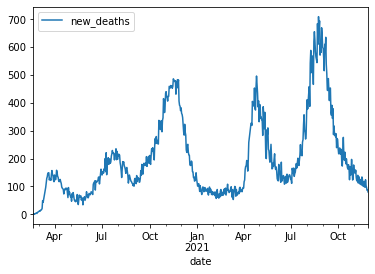

In [2]:
icf.plot(y='new_deaths')

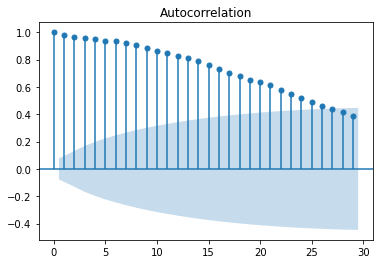

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
icn = icf.loc[:,'new_deaths']
plot_acf(icn);

In [4]:
icd = icn.diff(periods=1)
icd = icd[1:]
icd

date
2020-02-20    -2.00
2020-02-21     2.00
2020-02-22    -1.00
2020-02-23     2.00
2020-02-24     1.00
              ...  
2021-11-24   -21.00
2021-11-25    -7.00
2021-11-26   -10.00
2021-11-27     1.00
2021-11-28    -7.00
Name: new_deaths, Length: 648, dtype: float64

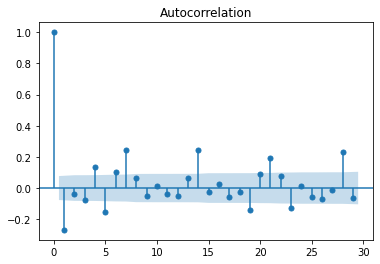

In [5]:
plot_acf(icd);

<AxesSubplot:xlabel='date'>

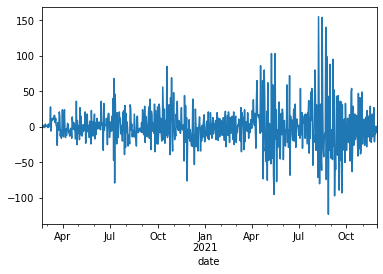

In [6]:
icd.plot()

**>> Using d = 1 (1 time differencing) the data becomes almost stationary.**

## Defining constants, spliting train and test for ARIMA

In [7]:
length = icn.shape[0]                #number of records
train_len = floor(length * 0.90)     #90% of records are going to be used for training
print('Out of', length, 'samples,', train_len, 'samples were devoted to training section and the rest (i.e.',
      length - train_len, 'samples) to test section.')
prl = 10                                    #prediction lendth: number of days to predict

xd = icn.values
xr = xd[:train_len]
xs = xd[train_len:train_len+prl]
xsp = []

Out of 649 samples, 584 samples were devoted to training section and the rest (i.e. 65 samples) to test section.


### Single set of parameters for an initial model

In [25]:
# Running ARIMA using p=10, d=1 and q=1
from statsmodels.tsa.arima.model import ARIMA
print('On', icf.index[train_len].strftime('%Y-%m-%d'), 'a prediction of', prl, 'days is as follows:')
arim = ARIMA(xr, order=(10, 1, 2))
arim_fit = arim.fit()

# print(arim_fit.aic)
xsp = arim_fit.forecast(steps=prl)
print('Using (p, d, q) = (3, 1, 1):')
for i in range (prl):
    print('Actual =', xs[i], '- predicted =', "{:2.1f}".format(xsp[i]))

On 2021-09-25 a prediction of 10 days is as follows:
Using (p, d, q) = (3, 1, 1):
Actual = 290 - predicted = 282.9
Actual = 278 - predicted = 278.6
Actual = 289 - predicted = 290.0
Actual = 239 - predicted = 280.5
Actual = 272 - predicted = 258.0
Actual = 268 - predicted = 242.9
Actual = 235 - predicted = 232.9
Actual = 217 - predicted = 229.8
Actual = 229 - predicted = 237.8
Actual = 238 - predicted = 245.1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
arim_fit.params


array([ 5.48121277e-01, -5.88852355e-01, -2.86437946e-01,  8.38168170e-02,
       -1.78427814e-01,  2.36934610e-01,  2.46550950e-01,  5.04011794e-02,
        1.88626348e-01,  1.39816461e-01, -1.01580635e+00,  8.47128959e-01,
        5.94873931e+02])

In [17]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt, floor
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, xsp)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, xsp)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, xsp))))

MAE:  Mean Absolute Error =            20.77
MAPE: Mean Absolute Percentage Error = 8.2%
RMSE: Root Mean Squared Error =        24.28


## Search to find the best parameters for ARIMA

### Constants

In [10]:
interval = 30    #interval: is going to be used for predictions at every 'interval' records
startp = 200     #start position: to start forcasting after this point

### Parameters sets

In [38]:
import itertools #To ease the process of combining parameters.

#Parameter values:
# pv = [1, 2, 3, 7, 10, 12, 14]#, 15, 16, 20]#, 30]#, 60]
pv = range(1, 20)
dv = range(0, 3)
qv = range(0, 3)
pdq = list(itertools.product(pv, dv, qv))
print(len(pdq), 'set of parameters are going to be compared:')


171 set of parameters are going to be compared:


### Fitting models and RMSE comparison within the training section

In [12]:
import warnings
import itertools
import math
from statistics import mean, stdev
warnings.filterwarnings('ignore')

lowest_rmse, best_cfg = float("inf"), None
cols = math.floor((train_len - startp - prl) / interval) #columns: is calculated to be used as the number of columns in this study
rmse = np.zeros([len(pdq), cols]) #root mean square error 
print('Search to find best parameters using', len(pdq), 'parameters sets in', cols, 'points of dataset:')
np.set_printoptions(precision=0)
fit_model = [None]*len(pdq)

for i in range(len(pdq)):
    print('Parameters set', i, ': (p, d, q) =', pdq[i])
    j = 0
    while j < cols:
        try:
            model = ARIMA(xr[:startp+j*interval], order=pdq[i])
            fit_model[i] = model.fit()
            xs = xr[startp+(j*interval):startp+(j*interval)+prl]
            xsp = fit_model[i].predict(start=startp+(j*interval), end=startp+(j*interval)+prl-1)
            print('On', startp + j*interval, 'Actuals =', xs, 'Predictions =', xsp)
            rmse[i][j] = sqrt(mean_squared_error(xs, xsp))
        except Exception as e:
            print(e)
            j += 1
            continue
        j += 1
       
    if mean(rmse[i]) < lowest_rmse:
        lowest_rmse, best_cfg = mean(rmse[i]), pdq[i]
    print("  > RMSE:","{:2.2f}".format(mean(rmse[i])))
      
print('********************************* Best Score *********************************')
print('Lowest RMSE', "{:2.2f}".format(lowest_rmse), 'was acheived using parameters set (p, d, q) =', best_cfg)
# print(rmse)


Search to find best parameters using 171 parameters sets in 12 points of dataset:
Parameters set 0 : (p, d, q) = (1, 0, 0)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [110. 109. 109. 109. 108. 108. 108. 107. 107. 107.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [231. 228. 225. 221. 218. 215. 212. 209. 206. 204.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [417. 414. 412. 410. 407. 405. 403. 401. 398. 396.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [345. 343. 342. 340. 338. 337. 335. 333. 332. 330.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [102. 103. 103. 104. 104. 105. 105. 105. 106. 106.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [73. 73. 74. 75. 75. 76. 77. 77. 78. 79.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [79. 79. 80. 80. 81. 82. 82. 83. 83. 84.]
On 410 Actuals = [161 172 174 193 185 155 

On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [101. 102. 102. 102. 102. 102. 102. 102. 102. 102.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [75. 73. 74. 73. 74. 74. 74. 74. 74. 74.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [82. 80. 82. 80. 82. 81. 82. 81. 81. 81.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [120. 120. 120. 120. 120. 120. 120. 120. 120. 120.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [397. 389. 396. 389. 396. 390. 395. 390. 395. 391.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [167. 167. 167. 167. 167. 167. 167. 167. 167. 167.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [128. 128. 128. 128. 128. 128. 128. 128. 128. 128.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [344. 339. 339. 339. 339. 339. 339. 339. 339. 339.]
  > RMSE: 47.84
Parameters set 6 : (p, d

On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [128. 128. 128. 128. 129. 129. 129. 129. 129. 129.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [342. 337. 335. 334. 333. 332. 330. 329. 328. 327.]
  > RMSE: 48.43
Parameters set 11 : (p, d, q) = (2, 0, 2)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [113. 111. 112. 111. 111. 110. 111. 110. 110. 109.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [221. 224. 220. 222. 219. 220. 218. 218. 216. 217.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [421. 420. 420. 419. 418. 418. 417. 417. 416. 416.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [351. 349. 349. 348. 348. 346. 346. 345. 345. 344.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [102. 104. 103. 104. 104. 105. 105. 106. 106. 107.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [75.

On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [93. 87. 81. 74. 68. 61. 55. 48. 42. 35.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [71. 70. 68. 66. 64. 63. 61. 59. 57. 56.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [81. 80. 80. 80. 79. 79. 79. 79. 79. 78.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [122. 125. 127. 129. 131. 133. 135. 137. 139. 142.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [392. 398. 402. 406. 410. 414. 419. 423. 427. 431.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [165. 158. 153. 148. 144. 139. 134. 129. 125. 120.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [126. 124. 123. 122. 120. 119. 117. 116. 115. 113.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [349. 352. 364. 370. 376. 383. 390. 397. 404. 411.]
  > RMSE: 44.95
Parameters set 17 : (p, d, q) = (2

On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [129. 129. 129. 129. 129. 129. 129. 129. 129. 129.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [345. 337. 332. 337. 338. 337. 337. 337. 337. 337.]
  > RMSE: 48.52
Parameters set 22 : (p, d, q) = (3, 1, 1)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [112. 113. 114. 113. 113. 113. 113. 113. 113. 113.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [222. 225. 223. 225. 223. 225. 224. 224. 224. 224.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [422. 424. 423. 423. 423. 423. 423. 423. 423. 423.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [354. 353. 354. 353. 353. 353. 353. 353. 353. 353.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [104. 105. 104. 104. 104. 104. 104. 104. 104. 104.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [76.

On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [353. 351. 352. 351. 351. 350. 349. 349. 348. 348.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [105. 106. 106. 106. 107. 107. 107. 108. 108. 108.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [76. 75. 76. 76. 77. 77. 78. 78. 79. 79.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [84. 83. 85. 84. 85. 85. 86. 86. 86. 87.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [120. 118. 118. 119. 119. 119. 119. 120. 120. 120.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [396. 386. 387. 386. 386. 384. 383. 382. 382. 381.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [168. 172. 171. 170. 170. 170. 171. 171. 170. 171.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [129. 130. 130. 130. 130. 131. 131. 131. 132. 132.]
On 530 Actuals = [411 378 409 434 458 38

On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [164. 172. 175. 176. 174. 173. 172. 171. 171. 171.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [134. 140. 142. 142. 142. 142. 143. 143. 144. 145.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [345. 337. 333. 339. 338. 338. 337. 338. 338. 338.]
  > RMSE: 39.02
Parameters set 33 : (p, d, q) = (4, 2, 0)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [114. 116. 113. 109. 108. 109. 107. 105. 104. 103.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [237. 244. 259. 276. 286. 296. 309. 322. 334. 346.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [442. 452. 451. 451. 460. 470. 474. 477. 483. 490.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [343. 335. 326. 318. 310. 303. 295. 287. 280. 272.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predicti

On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [424. 425. 421. 420. 421. 420. 419. 418. 418. 417.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [353. 351. 351. 350. 350. 349. 348. 348. 347. 347.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [104. 104. 104. 104. 105. 106. 106. 106. 107. 107.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [75. 74. 76. 76. 77. 77. 78. 78. 79. 79.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [84. 83. 84. 84. 85. 85. 85. 86. 86. 86.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [121. 118. 121. 121. 120. 122. 121. 122. 122. 122.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [383. 375. 392. 390. 375. 383. 394. 381. 377. 391.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [167. 170. 162. 158. 155. 154. 150. 148. 145. 143.]
On 500 Actuals = [111 165 157 146 166 13

On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [164. 162. 160. 164. 154. 146. 142. 140. 136. 134.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [132. 135. 135. 135. 133. 133. 134. 135. 135. 135.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [371. 362. 359. 362. 370. 393. 406. 412. 417. 424.]
  > RMSE: 36.86
Parameters set 44 : (p, d, q) = (5, 2, 2)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [108. 106. 107. 107. 107. 105. 103. 102. 100.  99.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [228. 228. 229. 235. 239. 243. 246. 249. 253. 256.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [436. 450. 459. 463. 469. 477. 487. 494. 502. 509.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [333. 316. 305. 293. 283. 272. 261. 249. 237. 225.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predicti

On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [431. 442. 451. 455. 458. 463. 469. 475. 480. 485.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [344. 337. 333. 326. 322. 316. 312. 307. 303. 299.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [103. 103.  97.  92.  87.  84.  82.  79.  76.  73.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [74. 70. 72. 69. 70. 68. 68. 67. 67. 66.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [87. 88. 92. 88. 88. 87. 89. 89. 90. 89.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [117. 116. 119. 122. 126. 129. 130. 132. 133. 136.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [397. 374. 381. 366. 373. 369. 372. 365. 366. 361.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [167. 167. 167. 172. 164. 157. 156. 155. 154. 153.]
On 500 Actuals = [111 165 157 146 166 13

On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [171. 173. 170. 173. 171. 170. 171. 171. 171. 171.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [130. 130. 130. 130. 130. 131. 131. 131. 132. 132.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [346. 333. 328. 332. 331. 334. 330. 328. 327. 326.]
  > RMSE: 47.62
Parameters set 55 : (p, d, q) = (7, 0, 1)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [112. 113. 114. 112. 113. 112. 112. 112. 112. 112.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [219. 221. 215. 215. 216. 220. 219. 219. 217. 216.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [424. 428. 426. 423. 423. 423. 423. 422. 421. 421.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [338. 327. 319. 309. 300. 290. 281. 271. 262. 253.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predicti

On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [446. 442. 446. 461. 475. 473. 473. 483. 496. 498.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [321. 317. 308. 302. 292. 279. 269. 256. 245. 237.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [101. 102. 100.  93.  81.  76.  73.  72.  68.  64.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [70. 69. 65. 63. 63. 60. 60. 55. 54. 52.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [87. 84. 91. 90. 87. 81. 83. 84. 86. 85.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [125. 126. 132. 141. 147. 154. 162. 166. 170. 176.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [385. 341. 328. 318. 312. 302. 314. 294. 275. 255.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [162. 176. 173. 179. 180. 164. 152. 158. 164. 163.]
On 500 Actuals = [111 165 157 146 166 13

On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [403. 367. 351. 331. 314. 312. 316. 315. 302. 286.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [158. 164. 163. 173. 175. 162. 152. 149. 151. 152.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [133. 138. 141. 143. 141. 138. 139. 142. 145. 147.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [370. 372. 354. 346. 338. 349. 374. 385. 384. 375.]
  > RMSE: 37.88
Parameters set 66 : (p, d, q) = (8, 1, 0)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [111. 112. 115. 115. 119. 116. 114. 113. 114. 115.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [222. 225. 221. 224. 220. 228. 232. 233. 229. 231.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [437. 431. 430. 440. 448. 443. 439. 442. 447. 445.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predicti

On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [224. 228. 225. 228. 227. 233. 238. 243. 244. 246.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [452. 463. 464. 471. 489. 500. 502. 508. 521. 533.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [324. 304. 293. 286. 278. 268. 255. 241. 226. 212.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [102. 102. 102. 100.  93.  82.  76.  74.  75.  73.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [75. 68. 68. 64. 63. 62. 61. 60. 57. 55.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [84. 86. 88. 91. 92. 89. 83. 83. 85. 88.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [116. 115. 119. 125. 131. 137. 143. 147. 149. 150.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [409. 371. 352. 329. 320. 320. 327. 330. 318. 298.]
On 470 Actuals = [170 155 128 122 120 17

On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [85. 86. 88. 91. 92. 88. 84. 84. 86. 88.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [114. 113. 116. 120. 125. 130. 134. 136. 136. 135.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [411. 376. 363. 346. 341. 340. 350. 355. 347. 333.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [158. 165. 165. 177. 177. 165. 154. 150. 154. 157.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [132. 135. 138. 140. 137. 133. 132. 134. 137. 139.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [373. 376. 360. 352. 344. 360. 387. 404. 406. 398.]
  > RMSE: 35.81
Parameters set 77 : (p, d, q) = (9, 1, 2)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [120. 126. 127. 122. 121. 121. 123. 123. 124. 125.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [222. 225. 223

On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [368. 365. 348. 334. 324. 341. 367. 379. 371. 353.]
  > RMSE: 37.14
Parameters set 82 : (p, d, q) = (10, 0, 1)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [107. 107. 107. 107. 110. 108. 106. 104. 103. 103.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [220. 220. 215. 215. 212. 216. 219. 220. 217. 216.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [446. 453. 446. 448. 463. 470. 466. 464. 470. 476.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [325. 305. 295. 288. 280. 271. 259. 247. 233. 221.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [104. 106. 108. 107. 101.  93.  90.  90.  93.  94.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [77. 73. 75. 71. 72. 73. 74. 75. 75. 76.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [ 87.  89.  92.  95.  9

On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [76. 68. 67. 65. 62. 62. 61. 59. 57. 54.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [83. 84. 89. 89. 92. 88. 83. 80. 85. 87.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [115. 114. 121. 126. 132. 139. 144. 148. 150. 151.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [412. 377. 356. 332. 325. 324. 335. 332. 330. 304.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [155. 159. 160. 173. 172. 157. 146. 139. 138. 142.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [133. 138. 139. 141. 139. 135. 134. 137. 140. 142.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [378. 386. 372. 366. 361. 376. 409. 433. 442. 441.]
  > RMSE: 33.69
Parameters set 88 : (p, d, q) = (10, 2, 1)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [111. 112. 114. 116. 120. 120. 11

On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [369. 373. 354. 346. 336. 348. 372. 385. 384. 375.]
  > RMSE: 36.26
Parameters set 93 : (p, d, q) = (11, 1, 0)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [111. 111. 113. 115. 118. 118. 117. 113. 113. 114.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [221. 225. 221. 223. 221. 227. 231. 237. 237. 236.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [454. 456. 453. 447. 468. 480. 477. 471. 480. 490.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [330. 315. 307. 310. 305. 299. 291. 282. 276. 269.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [103. 106. 106. 106.  99.  90.  84.  86.  89.  90.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [76. 69. 69. 67. 65. 66. 66. 64. 63. 61.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [83. 84. 89. 88. 92. 87

On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [100.  99.  96.  94.  88.  78.  71.  72.  72.  68.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [77. 69. 70. 69. 68. 68. 67. 65. 63. 59.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [82. 82. 86. 87. 91. 88. 83. 81. 86. 88.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [115. 115. 123. 128. 132. 138. 141. 145. 147. 148.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [416. 380. 367. 345. 342. 340. 354. 354. 356. 335.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [159. 163. 165. 177. 179. 164. 156. 150. 153. 157.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [134. 136. 138. 140. 139. 134. 134. 136. 139. 140.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [372. 377. 359. 353. 344. 358. 388. 406. 409. 401.]
  > RMSE: 35.83
Parameters set 99 : (p, 

On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [132. 136. 137. 139. 137. 133. 132. 134. 137. 138.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [372. 376. 359. 350. 342. 355. 384. 402. 404. 397.]
  > RMSE: 35.85
Parameters set 104 : (p, d, q) = (12, 1, 2)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [115. 110. 108. 112. 121. 121. 115. 109. 109. 114.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [216. 222. 224. 226. 218. 222. 230. 238. 238. 233.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [453. 457. 450. 444. 464. 482. 481. 468. 469. 486.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [334. 316. 306. 309. 312. 306. 292. 281. 279. 279.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [102. 104. 102. 102.  95.  85.  79.  81.  84.  84.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [7

On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [323. 305. 293. 293. 285. 276. 265. 252. 240. 229.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [104. 108. 108. 108. 102.  94.  89.  92.  95.  97.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [78. 72. 73. 72. 70. 73. 73. 74. 75. 74.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [85. 87. 92. 92. 97. 93. 89. 88. 94. 97.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [114. 112. 118. 123. 128. 134. 137. 140. 141. 140.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [412. 370. 352. 327. 318. 314. 324. 319. 315. 285.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [158. 162. 164. 176. 176. 163. 154. 148. 150. 155.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [134. 138. 141. 143. 141. 138. 138. 141. 144. 147.]
On 530 Actuals = [411 378 409 434 458 38

On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [155. 155. 156. 172. 173. 153. 139. 134. 137. 137.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [131. 135. 140. 139. 137. 137. 132. 135. 140. 142.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [378. 388. 371. 369. 362. 382. 412. 439. 448. 439.]
  > RMSE: 33.77
Parameters set 115 : (p, d, q) = (13, 2, 1)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [113. 111. 110. 109. 112. 111. 110. 105. 103. 104.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [224. 229. 230. 234. 229. 238. 244. 252. 254. 259.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [459. 465. 457. 452. 480. 504. 509. 501. 511. 532.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [323. 310. 299. 301. 292. 282. 263. 249. 237. 226.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predic

On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [456. 458. 449. 443. 469. 486. 484. 471. 479. 496.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [328. 316. 307. 312. 307. 302. 290. 283. 276. 271.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [104. 105. 104. 104.  96.  88.  81.  84.  86.  87.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [76. 70. 68. 67. 67. 67. 65. 66. 64. 61.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [82. 83. 88. 89. 92. 86. 83. 79. 85. 87.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [113. 112. 117. 122. 125. 129. 133. 135. 135. 134.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [412. 377. 370. 337. 333. 343. 361. 357. 355. 333.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [158. 159. 161. 177. 180. 162. 149. 146. 150. 152.]
On 500 Actuals = [111 165 157 146 166 13

On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [407. 369. 361. 326. 313. 319. 333. 317. 300. 268.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [137. 129. 130. 157. 171. 155. 129. 105. 100. 106.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [138. 145. 151. 152. 149. 148. 144. 146. 150. 155.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [375. 385. 371. 370. 366. 387. 418. 442. 450. 439.]
  > RMSE: 32.89
Parameters set 126 : (p, d, q) = (15, 0, 0)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [112. 110. 110. 111. 115. 115. 114. 110. 107. 109.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [219. 221. 218. 219. 211. 218. 220. 224. 221. 222.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [454. 455. 445. 438. 462. 478. 475. 460. 466. 480.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predic

On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [219. 226. 223. 228. 222. 224. 235. 236. 239. 237.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [458. 458. 453. 439. 468. 493. 491. 484. 481. 503.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [328. 315. 313. 314. 312. 303. 292. 277. 275. 269.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [104. 105. 102. 100.  94.  85.  80.  81.  84.  85.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [76. 70. 69. 66. 67. 70. 67. 65. 65. 62.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [82. 81. 86. 88. 94. 88. 83. 79. 83. 86.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [118. 117. 120. 121. 122. 126. 131. 137. 140. 139.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [410. 375. 372. 343. 328. 346. 370. 359. 351. 333.]
On 470 Actuals = [170 155 128 122 120 17

On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [ 85.  86.  92.  95. 101.  95.  92.  91.  98. 103.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [115. 114. 120. 125. 128. 132. 136. 140. 141. 141.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [407. 371. 364. 333. 315. 329. 345. 331. 318. 291.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [145. 151. 150. 169. 172. 154. 134. 128. 135. 139.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [130. 134. 140. 142. 139. 140. 138. 138. 144. 149.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [368. 374. 354. 346. 336. 351. 378. 394. 397. 379.]
  > RMSE: 35.88
Parameters set 137 : (p, d, q) = (16, 0, 2)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [116. 112. 111. 110. 114. 113. 112. 108. 106. 108.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [2

On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [377. 388. 372. 368. 363. 383. 416. 440. 452. 442.]
  > RMSE: 33.73
Parameters set 142 : (p, d, q) = (16, 2, 1)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [118. 114. 113. 113. 118. 118. 117. 114. 113. 115.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [219. 228. 225. 230. 225. 227. 239. 241. 244. 243.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [457. 461. 455. 443. 472. 500. 497. 491. 488. 511.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [322. 304. 297. 295. 287. 272. 254. 233. 223. 211.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [102. 102.  96.  93.  86.  77.  71.  70.  72.  71.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [76. 69. 68. 65. 66. 68. 65. 62. 61. 57.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [83. 83. 88. 90. 95. 8

On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [104. 105. 102. 100.  95.  87.  81.  82.  85.  86.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [77. 70. 69. 66. 67. 70. 67. 65. 65. 62.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [83. 83. 88. 90. 94. 87. 83. 81. 86. 89.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [114. 113. 118. 122. 125. 129. 132. 136. 136. 135.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [407. 369. 365. 335. 316. 330. 355. 339. 325. 306.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [150. 158. 160. 178. 183. 164. 144. 141. 152. 156.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [130. 133. 138. 139. 134. 134. 132. 131. 135. 139.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [373. 380. 361. 354. 346. 363. 391. 412. 418. 404.]
  > RMSE: 35.68
Parameters set 148 : (p,

On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [132. 125. 118. 151. 168. 155. 126. 102.  91.  94.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [129. 135. 142. 144. 141. 143. 137. 136. 143. 146.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [370. 379. 372. 377. 375. 387. 414. 433. 446. 440.]
  > RMSE: 32.67
Parameters set 153 : (p, d, q) = (18, 0, 0)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [116. 111. 110. 110. 114. 113. 111. 108. 106. 108.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [215. 221. 216. 219. 211. 211. 219. 219. 219. 215.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [455. 455. 447. 432. 459. 484. 478. 471. 465. 484.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [322. 305. 298. 295. 288. 274. 257. 236. 227. 215.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predic

On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [457. 457. 449. 438. 471. 499. 494. 485. 481. 503.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [323. 305. 299. 296. 290. 274. 259. 236. 231. 218.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [109. 113. 111. 112. 108. 104. 102. 108. 116. 123.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [81. 76. 78. 77. 80. 84. 84. 85. 87. 87.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [84. 86. 91. 94. 99. 93. 90. 88. 94. 99.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [114. 113. 120. 123. 127. 130. 134. 137. 139. 138.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [400. 360. 349. 315. 292. 302. 316. 299. 277. 244.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [139. 141. 138. 167. 179. 166. 147. 136. 137. 142.]
On 500 Actuals = [111 165 157 146 166 13

On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [115. 114. 120. 125. 129. 132. 136. 140. 142. 142.]
On 440 Actuals = [344 349 338 335 283 386 351 307 366 297] Predictions = [401. 361. 349. 316. 294. 303. 315. 297. 274. 239.]
On 470 Actuals = [170 155 128 122 120 179 157 153 124 115] Predictions = [139. 146. 146. 173. 178. 162. 141. 133. 139. 148.]
On 500 Actuals = [111 165 157 146 166 136 146 151 165 182] Predictions = [132. 136. 142. 145. 144. 146. 142. 144. 150. 152.]
On 530 Actuals = [411 378 409 434 458 387 542 588 508 536] Predictions = [368. 373. 354. 346. 336. 351. 378. 394. 396. 379.]
  > RMSE: 36.85
Parameters set 164 : (p, d, q) = (19, 0, 2)
On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [119. 116. 112. 109. 115. 117. 116. 111. 109. 113.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [215. 218. 216. 219. 209. 210. 218. 217. 219. 212.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predic

On 200 Actuals = [139 117 132 127 129 115 116 128 156 140] Predictions = [118. 113. 111. 107. 110. 110. 109. 104. 101. 101.]
On 230 Actuals = [227 239 230 210 195 251 272 254 279 256] Predictions = [222. 229. 230. 236. 231. 235. 248. 251. 258. 257.]
On 260 Actuals = [406 424 423 459 458 453 462 457 461 452] Predictions = [459. 459. 455. 443. 472. 498. 497. 493. 489. 511.]
On 290 Actuals = [321 294 284 323 295 284 231 222 247 251] Predictions = [322. 305. 298. 295. 288. 273. 255. 234. 225. 212.]
On 320 Actuals = [110  98  82 103  85  82  71  91  98  97] Predictions = [102. 101.  97.  93.  86.  76.  70.  71.  71.  71.]
On 350 Actuals = [79 67 80 76 57 67 89 61 65 58] Predictions = [76. 69. 68. 65. 65. 68. 64. 62. 61. 56.]
On 380 Actuals = [81 82 93 99 81 61 88 53 73 88] Predictions = [83. 83. 88. 91. 95. 89. 84. 82. 86. 90.]
On 410 Actuals = [161 172 174 193 185 155 193 258 274 291] Predictions = [117. 117. 123. 128. 132. 136. 141. 146. 149. 151.]
On 440 Actuals = [344 349 338 335 283 38

### Prediction in test section using best set of parameters found above and calculations of errors:

In [36]:
xs = xd[train_len : train_len + prl]
print('On', icf.index[train_len].strftime('%Y-%m-%d'), 'a prediction of', prl, 'days is as follows:')
try:
    print('Using the best found set of parameters (p, d, q) =', best_cfg, ':')
    xsp = ARIMA(xr, order=best_cfg).fit().predict(start=train_len, end=train_len+prl-1)
    for i in range (prl):
        print('Actual =', xs[i], '- predicted =', "{:2.1f}".format(xsp[i]))    

    print('\nMAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, xsp)))
    print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, xsp)))
    print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, xsp))))
except Exception as e:
    print(e)

On 2021-09-25 a prediction of 10 days is as follows:
Using the best found set of parameters (p, d, q) = (6, 1, 2) :
Actual = 290 - predicted = 294.6
Actual = 278 - predicted = 269.1
Actual = 289 - predicted = 279.8
Actual = 239 - predicted = 252.0
Actual = 272 - predicted = 245.0
Actual = 268 - predicted = 227.2
Actual = 235 - predicted = 225.0
Actual = 217 - predicted = 212.8
Actual = 229 - predicted = 211.3
Actual = 238 - predicted = 202.0

MAE:  Mean Absolute Error =            17.14
MAPE: Mean Absolute Percentage Error = 6.8%
RMSE: Root Mean Squared Error =        21.14


## Conclusion

**>> In this notebook, we have established a technique to find the best set of parameters for ARIMA model in prediction of daily new deaths of corona. Briefly, the technique uses several points in the training section for the model to fit an ARIMA model and then use the fit model to predict some future values.**

**Several attempts were made to implement the abovementioned searching and assessment techniques. The above technique can avoid overfitting by using tests that are outside of the training boundaries of each model.**

**The model shows an acceptable performance within 10 days after the final available data. This model is based on the previous samples of the studied feature. Also as we are using the local data only, it cannot predict new peaks in cases/deaths using worldwide new variants outbreak. This limits the application of ARIMA to short term predictions (such as 1 or 2 weeks).**